In [2]:
import numpy as np
import pandas as pd
import datetime
from dateutil.parser import parse
import requests, re, time
import pandas_datareader
import pickle
import math

import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.lines import Line2D
import matplotlib.patches as mpatches
import seaborn as sns 

import statsmodels.api as sm
import json
from pandas.io.json import json_normalize
from bs4 import BeautifulSoup
from selenium import webdriver
import time

import geopy.distance

# The Impact of Metro-Construction: A Regressive Study

In the following, I seek to find the effect on the price of Copenhagen apartments from the construction of a nearby metro. 

First, I scrape data of all sold condos in Copenhagen since 1992 using Boliga.dk. Second, I use Google's Geocoding-API to convert the found addresses to coordinates. This will help me in step four. Third, I scrape Wikipedia for information on Copenhagen Metro stations. Fourth, I want to find the cloest metro to each apartment, and estimate the distance between the two. This is found to be most easily done by finding coordinates to each apartment and metro, calculate the distance between each apartment and its closest metro and therefrom infer a distance. As the found distance is in the form of a straight line, one must keep in line that the actual walking/cycling distance is longer. Fifth, I must take relevant factors into account in an econometric analysis.

This enables me to isolate the effect on the price of a condo from construction of a nearby metro station.

The structure of this code-file is the following:

1) Scraping Boliga.dk the old-fashioned selenium-way

2) Geocoding the found addresses, fetching their coordinates. Now having all relevant data on the apartments.

3) Fetching the same data via the API of Boliga.dk (Coordinates are included here, a great bonus)

4) Scraping wikipedia for metro stations using selenium

5) Finding the closest metro to each apartment

# 1) Scraping sales-data from Boliga.dk

## 1.1) Scraping

In [21]:
### Define our Connector

import requests,os,time
def ratelimit(dt):
    "A function that handles the rate of your calls."
    time.sleep(dt) # sleep one second.

class Connector():
  def __init__(self,logfile,overwrite_log=False,connector_type='requests',session=False,path2selenium='',n_tries = 5,timeout=30,waiting_time=0.5):
    """This Class implements a method for reliable connection to the internet and monitoring. 
    It handles simple errors due to connection problems, and logs a range of information for basic quality assessments
    
    Keyword arguments:
    logfile -- path to the logfile
    overwrite_log -- bool, defining if logfile should be cleared (rarely the case). 
    connector_type -- use the 'requests' module or the 'selenium'. Will have different since the selenium webdriver does not have a similar response object when using the get method, and monitoring the behavior cannot be automated in the same way.
    session -- requests.session object. For defining custom headers and proxies.
    path2selenium -- str, sets the path to the geckodriver needed when using selenium.
    n_tries -- int, defines the number of retries the *get* method will try to avoid random connection errors.
    timeout -- int, seconds the get request will wait for the server to respond, again to avoid connection errors.
    """
    
    ## Initialization function defining parameters. 
    self.n_tries = n_tries # For avoiding triviel error e.g. connection errors, this defines how many times it will retry.
    self.timeout = timeout # Defining the maximum time to wait for a server to response.
    self.waiting_time = waiting_time # define simple rate_limit parameter.
    ## not implemented here, if you use selenium.
    if connector_type=='selenium':
      assert path2selenium!='', "You need to specify the path to you geckodriver if you want to use Selenium"
      from selenium import webdriver
      ## HIN download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases

      assert os.path.isfile(path2selenium),'You need to insert a valid path2selenium the path to your geckodriver. You can download the latest geckodriver here: https://github.com/mozilla/geckodriver/releases'
      self.browser = webdriver.Firefox(executable_path=path2selenium) # start the browser with a path to the geckodriver.

    self.connector_type = connector_type # set the connector_type
    
    if session: # set the custom session
      self.session = session
    else:
      self.session = requests.session()
    self.logfilename = logfile # set the logfile path
    ## define header for the logfile
    header = ['id','project','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
    if os.path.isfile(logfile):        
      if overwrite_log==True:
        self.log = open(logfile,'w')
        self.log.write(';'.join(header))
      else:
        self.log = open(logfile,'a')
    else:
      self.log = open(logfile,'w')
      self.log.write(';'.join(header))
    ## load log 
    with open(logfile,'r') as f: # open file
        
      l = f.read().split('\n') # read and split file by newlines.
      ## set id
      if len(l)<=1:
        self.id = 0
      else:
        self.id = int(l[-1][0])+1
            
  def get(self,url,project_name):
    """Method for connector reliably to the internet, with multiple tries and simple error handling, as well as default logging function.
    Input url and the project name for the log (i.e. is it part of mapping the domain, or is it the part of the final stage in the data collection).
    
    Keyword arguments:
    url -- str, url
    project_name -- str, Name used for analyzing the log. Use case could be the 'Mapping of domain','Meta_data_collection','main data collection'. 
    """
     
    project_name = project_name.replace(';','-') # make sure the default csv seperator is not in the project_name.
    if self.connector_type=='requests': # Determine connector method.
      for _ in range(self.n_tries): # for loop defining number of retries with the requests method.
        ratelimit(self.waiting_time)
        t = time.time()
        try: # error handling 
          response = self.session.get(url,timeout = self.timeout) # make get call

          err = '' # define python error variable as empty assumming success.
          success = True # define success variable
          redirect_url = response.url # log current url, after potential redirects 
          dt = t - time.time() # define delta-time waiting for the server and downloading content.
          size = len(response.text) # define variable for size of html content of the response.
          response_code = response.status_code # log status code.
          ## log...
          call_id = self.id # get current unique identifier for the call
          self.id+=1 # increment call id
          #['id','project_name','connector_type','t', 'delta_t', 'url', 'redirect_url','response_size', 'response_code','success','error']
          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row to be written in the log.
          self.log.write('\n'+';'.join(map(str,row))) # write log.
          self.log.flush()
          return response,call_id # return response and unique identifier.

        except Exception as e: # define error condition
          err = str(e) # python error
          response_code = '' # blank response code 
          success = False # call success = False
          size = 0 # content is empty.
          redirect_url = '' # redirect url empty 
          dt = t - time.time() # define delta t

          ## log...
          call_id = self.id # define unique identifier
          self.id+=1 # increment call_id

          row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row
          self.log.write('\n'+';'.join(map(str,row))) # write row to log.
          self.log.flush()
    else:
      t = time.time()
      ratelimit(self.waiting_time)
      self.browser.get(url) # use selenium get method
      ## log
      call_id = self.id # define unique identifier for the call. 
      self.id+=1 # increment the call_id
      err = '' # blank error message
      success = '' # success blank
      redirect_url = self.browser.current_url # redirect url.
      dt = t - time.time() # get time for get method ... NOTE: not necessarily the complete load time.
      size = len(self.browser.page_source) # get size of content ... NOTE: not necessarily correct, since selenium works in the background, and could still be loading.
      response_code = '' # empty response code.
      row = [call_id,project_name,self.connector_type,t,dt,url,redirect_url,size,response_code,success,err] # define row 
      self.log.write('\n'+';'.join(map(str,row))) # write row to log file.
      self.log.flush()
    # Using selenium it will not return a response object, instead you should call the browser object of the connector.
    ## connector.browser.page_source will give you the html.
      return None,call_id

### Defining aiding functions for later use in the scraper:

In [22]:
path2gecko = '/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Gecko/geckodriver'

def Cookie_Clicker(): # Accepting cookies
    cookies = connector.browser.find_element_by_xpath('//*[@id="coiAccept"]')
    cookies.click()
        
def Next_Page(): # Turning to the next page of apartments in the scraper
    next_button = connector.browser.find_element_by_link_text('Næste')
    next_button.click()

### Defining the scraping-function:

In [23]:
connector = Connector('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Logs/Selenium Scrape.csv',overwrite_log=True,path2selenium=path2gecko,connector_type='selenium')

def Scraper(pages,url):
    url_base = url
    
    connector.get(url_base,'Selenium Scrape')
    start_time = time.time()

    #Waiting for cookies-pop-up:
    time.sleep(5)

    #Accepting cookies:
    Cookie_Clicker()

    #Wait for load:
    time.sleep(3)

    #Pull table
    df = pd.read_html(connector.browser.page_source)[0]
    time.sleep(2)

    #Looping over number of wanted pages:
    for i in range(0,pages-1): # Minus one as we already scraped the initial page.
        if i%100 == 0:
            print(f'Page {i} finished')
        try:
            Next_Page(True)
            time.sleep(1)
            df_i = pd.read_html(connector.browser.page_source)[0]
            df = pd.concat([df,df_i],ignore_index=True)
        except:
            print('Error')

    print(f'Time elapsed: {time.time()-start_time: .2f}')
    return df

### Calling scraper:

I find, that the log-file only logs one entry using this selenium-driven scraper. This is probably due to the fact that the site only loads once, after which the scraper clicks 'Next' and the next table loads, however still on the same request. This is a downside to the manual scraper, as less information on the scraping is harvested. 


In [24]:
# Scraping Copenhagen
url_broaderCPH = 'https://www.boliga.dk/salg/resultater?propertyType=3&salesDateMin=1992&street=&municipality=101&page=1&sort=date-d'

df_broaderCPH = Scraper(1110,url_broaderCPH)

Page 0 finished
Page 100 finished
Page 200 finished
Page 300 finished
Page 400 finished
Page 500 finished
Page 600 finished
Page 700 finished
Page 800 finished
Page 900 finished
Page 1000 finished
Page 1100 finished
Time elapsed:  1778.02


In [25]:
# Checking first log:
log_CPH = pd.read_csv('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Logs/Selenium Scrape.csv',sep=';')
log_CPH

,id,project,connector_type,t,delta_t,url,redirect_url,response_size,response_code,success,error
0,0,Selenium Scrape,selenium,1.598262e+09,-2.55473,https://www.boliga.dk/salg/resultater?property...,https://www.boliga.dk/salg/resultater?property...,786473,NaN,NaN,NaN


In [27]:
df_broaderCPH.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Scrape broaderCPH raw.pkl')
log_CPH.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/log CPH_scrape.pkl')

In [29]:
# Scraping Frederiksberg
connector = Connector('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Logs/Selenium Scrape.csv',overwrite_log=False,path2selenium=path2gecko,connector_type='selenium')
url_FRB = 'https://www.boliga.dk/salg/resultater?propertyType=3&salesDateMin=1992&street=&municipality=147&page=1&sort=date-d'

df_FRB = Scraper(247,url_FRB)

Page 0 finished
Page 100 finished
Page 200 finished
Time elapsed:  390.85


In [34]:
# Checking that the second scrape is logged:
log_FRB = pd.read_csv('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Logs/Selenium Scrape.csv',sep=';')
log_FRB

,id,project,connector_type,t,delta_t,url,redirect_url,response_size,response_code,success,error
0,0,Selenium Scrape,selenium,1.598262e+09,-2.554730,https://www.boliga.dk/salg/resultater?property...,https://www.boliga.dk/salg/resultater?property...,786473,NaN,NaN,NaN
1,1,Selenium Scrape,selenium,1.598267e+09,-2.466936,https://www.boliga.dk/salg/resultater?property...,https://www.boliga.dk/salg/resultater?property...,787563,NaN,NaN,NaN


In [35]:
df_FRB.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Scrape FRB raw.pkl')
log_FRB.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/log FRB_scrape.pkl')

In [36]:
df_Total = pd.concat([df_broaderCPH,df_FRB],ignore_index=True)

In [37]:
# Checking total yield:
print(f'Total dataframe has {len(df_Total)} rows.')
df_Total.head(n=3)

Total dataframe has 67850 rows.


,Adresse,Købesum,Salgsdato,Boligtype,Kr. / m²,Værelser,m²,Byggeår,Den procentuelle forskel mellem seneste udbudspris og salgsprisen %,Unnamed: 9
0,"Pakhusvej 6, 1. tv, 2100 København Ø",Købesum 2.700.000,Salgsdato 13-08-2020,Boligtype Ejerlejlighed EEjerlejlighed,Kr. / m² 26.471,Værelser 3,m² 102 m²,Byggeår 2007,Prisjustering,BoligrapporterBoligrapporterFå de bedste argum...
1,"Ålekistevej 108A, 5, 2720 Vanløse",Købesum 2.400.000,Salgsdato 13-08-2020,Boligtype Ejerlejlighed EEjerlejlighed,Kr. / m² 28.916,Værelser 3,m² 83 m²,Byggeår 1937,Prisjustering -4%,BoligrapporterBoligrapporterFå de bedste argum...
2,"Kærholmen 19, 1. tv, 2720 Vanløse",Købesum 2.095.000,Salgsdato 12-08-2020,Boligtype Ejerlejlighed EEjerlejlighed,Kr. / m² 36.121,Værelser 2,m² 58 m²,Byggeår 1939,Prisjustering -5%,BoligrapporterBoligrapporterFå de bedste argum...


## 1.1.2) Working with the data:

In [38]:
Apartments = pd.DataFrame()
Apartments['Address'] = df_Total['Adresse']

# Translating to english and datetime
dates = [i[10:] for i in df_Total['Salgsdato']]
Apartments['Date_sold'] = [datetime.datetime(year=int(i[6:]),month=int(i[3:5]),day=int(i[:2]),)
    for i in dates
]

Apartments['Price'] = [int(i[8:].replace('.',''))
    for i in df_Total['Købesum']
]

Apartments['Price_sq_m'] = [int(i[9:].replace('.',''))
    for i in df_Total['Kr. / m²']
]

Apartments['Rooms'] = [int(i[9:])
    for i in df_Total['Værelser']
]

Apartments.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data 1.pkl')

In [39]:
Apartments = pickle.load(open('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data 1.pkl','rb'))
Apartments.head(n=3)

,Address,Date_sold,Price,Price_sq_m,Rooms
0,"Pakhusvej 6, 1. tv, 2100 København Ø",2020-08-13,2700000,26471,3
1,"Ålekistevej 108A, 5, 2720 Vanløse",2020-08-13,2400000,28916,3
2,"Kærholmen 19, 1. tv, 2720 Vanløse",2020-08-12,2095000,36121,2


A new column is added, using RegEx to remove all text between the commas. This substring expresses which door in the given apartment complex the address belongs to, and is thus irrelevant for the distance to nearest Metro. This is due to a later issue with the API not being able to recognize the address otherwise.

In [40]:
Apartments['Address transformed'] = [re.sub(',[^>]+,', '',i)
for i in Apartments['Address']
    ]
Apartments.head(n=3)

,Address,Date_sold,Price,Price_sq_m,Rooms,Address transformed
0,"Pakhusvej 6, 1. tv, 2100 København Ø",2020-08-13,2700000,26471,3,Pakhusvej 6 2100 København Ø
1,"Ålekistevej 108A, 5, 2720 Vanløse",2020-08-13,2400000,28916,3,Ålekistevej 108A 2720 Vanløse
2,"Kærholmen 19, 1. tv, 2720 Vanløse",2020-08-12,2095000,36121,2,Kærholmen 19 2720 Vanløse


### Sorting data by address and date sold:

In [43]:
data_sorted = Apartments.sort_values(['Address','Date_sold'])

# Problem with some pgaes being scraped more than once - deleting duplicate rows:
data_sorted.drop_duplicates(inplace=True)
data_sorted = data_sorted.sort_values(['Date_sold'])
data_sorted['Price_mio'] = data_sorted['Price']/10**6
data_sorted['Price_sq_m_1000'] = data_sorted['Price_sq_m']/10**3
data_sorted = data_sorted.reset_index()

# Sorting and creating daily averages and moving average for graphing:
dailyavg = data_sorted.groupby('Date_sold').agg(
    Dailyavg_mio = ('Price_mio','mean'),
    Dailyavg_sq = ('Price_sq_m_1000','mean')
)
dailyavg['Day'] = dailyavg.index.to_list()
dailyavg['MovAvg'] = dailyavg['Dailyavg_sq'].rolling(window=500,center=True).mean()

In [44]:
# The apartment data now looks like this:
Apartments = data_sorted
Apartments.head(n=3)

,level_0,index,Address,Date_sold,Price,Price_sq_m,Rooms,Address transformed,Price_mio,Price_sq_m_1000
0,0,67849,"Sankt Thomas Alle 11, 4. th, 1824 Frederiksberg C",1992-01-24,725800,6598,4,Sankt Thomas Alle 11 1824 Frederiksberg C,0.7258,6.598
1,1,67848,"Moltkesvej 61, st. th, 2000 Frederiksberg",1992-01-26,690000,7841,4,Moltkesvej 61 2000 Frederiksberg,0.6900,7.841
2,2,67847,"Frederiksberg Alle 34, 1. th, 1820 Frederiksbe...",1992-02-02,1250000,6188,6,Frederiksberg Alle 34 1820 Frederiksberg C,1.2500,6.188


In [45]:
# The grouped mean- and moving average-data looks like this (MovAvg has NaN-values in beginning and ending of series):
dailyavg.head(n=3)

,Dailyavg_mio,Dailyavg_sq,Day,MovAvg
Date_sold,,,,
1992-01-24,0.7258,6.598,1992-01-24,NaN
1992-01-26,0.6900,7.841,1992-01-26,NaN
1992-02-02,1.2500,6.188,1992-02-02,NaN


### Splitting the apartments by sub-areas within Copenhagen:

In [46]:
# Inferring the area from the last part of the address:
Apartments['Area'] = 'NaN'
for i in range(0,len(Apartments)):
    if Apartments['Address'][i][-1] == 'N':
        Apartments['Area'][i] = 'N'
        # Solving issue with differentiating between NV and V:
    elif Apartments['Address'][i][-2:] == 'NV':
        if Apartments['Address'][i][-2] == ' V':
            Apartments['Area'][i] = 'V'
        else: 
            Apartments['Area'][i] = 'NV'
    elif Apartments['Address'][i][-1] == 'Ø':
        Apartments['Area'][i] = 'Ø'
    elif Apartments['Address'][i][-1] == 'K':
        Apartments['Area'][i] = 'K'
    elif Apartments['Address'][i][-1] == 'S':
        Apartments['Area'][i] = 'S'
    elif Apartments['Address'][i][-5:] == 'Valby':
        Apartments['Area'][i] = 'Valby'
    elif Apartments['Address'][i][-13:] == 'Frederiksberg':
        Apartments['Area'][i] = 'FRB'
    elif Apartments['Address'][i][-1:] == 'C':
        Apartments['Area'][i] = 'FRB'

In [47]:
Apartments.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data 2.pkl')
Apartments = pickle.load(open('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data 2.pkl','rb'))

In [48]:
Apartments.head(n=3)

,level_0,index,Address,Date_sold,Price,Price_sq_m,Rooms,Address transformed,Price_mio,Price_sq_m_1000,Area
0,0,67849,"Sankt Thomas Alle 11, 4. th, 1824 Frederiksberg C",1992-01-24,725800,6598,4,Sankt Thomas Alle 11 1824 Frederiksberg C,0.7258,6.598,FRB
1,1,67848,"Moltkesvej 61, st. th, 2000 Frederiksberg",1992-01-26,690000,7841,4,Moltkesvej 61 2000 Frederiksberg,0.6900,7.841,FRB
2,2,67847,"Frederiksberg Alle 34, 1. th, 1820 Frederiksbe...",1992-02-02,1250000,6188,6,Frederiksberg Alle 34 1820 Frederiksberg C,1.2500,6.188,FRB


# 2) Geocoding: Address to coordinates

## 2.1) Defining the Geocoding-function, finding coordinates from a given address:

Defining a function which returns the coordinates for a given address, using the Google Geocode API. I am using a free voucher of DKK 2,000. I need to pull coordinates for around 55 thousand adresses, this will spend around DKK 2,000. All covered by credits for new users.

In [76]:
geo_url = 'https://maps.googleapis.com/maps/api/geocode/json'
def Geocode_Google(address):
    spec_params = {'key' : #REMOVED
          'address' : address,
    }
    d = requests.get(geo_url, params=spec_params)
    json_data = d.json()
    subdata = json_data['results']
    return (subdata[0]['geometry']['location']['lat'],subdata[0]['geometry']['location']['lng'])

## 2.2) Finding Coordinates to each apartment:

Below, I use the Geocode-function to pull coordinates for all apartments in the dataset. This process took around 8 hours, so I split it up into stages, saving to pickle for each pull in intervals of 5000 pulls, after which I concatenate to a single dataframe and add this column to the original dataset for each apartment. Below, this process has been simplified for easier readability. The stage-pickles are saved in the /Pickles-folder.

In [ ]:
Apartments['Coordinates'] = [Geocode_Google(i) for i in Apartments['Address transformed']]

In [ ]:
Apartments.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data 3.pkl')

In [26]:
Apartments = pickle.load(open('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data 3.pkl','rb'))

In [27]:
Apartments.head(n=3)

,Address,Address transformed,Area,Coordinates,Date_sold,Price,Price_mio,Price_sq_m_1000,Rooms
0,"Stengade 52B, 1. 1, 2200 København N",Stengade 52B 2200 København N,N,"(55.687083, 12.554688)",1994-02-11,300710,0.300710,5.896,1
1,"Bryggerivej 10, 1. th, 2500 Valby",Bryggerivej 10 2500 Valby,Valby,"(55.660475, 12.518974)",1994-02-11,344101,0.344101,5.550,2
2,"Solvænget 5, 3. tv, 2100 København Ø",Solvænget 5 2100 København Ø,Ø,"(55.719198, 12.57804)",1994-02-11,1090300,1.090300,7.788,4


The result above is a cleaned dataframe of the basic information on all the scraped apartments - before the closest metro is found. 

# 3) Using Boliga.dk's API

Using the same connector as defined above, I now call the API of the page via requests instead and see, what kind of apartment-data I get this way, and how it differs from the selenium-scrape.

## 3.1) Fetching data

In [51]:
connector = Connector('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Logs/API Scrape.csv',overwrite_log=True,path2selenium=path2gecko,connector_type='requests')

In [52]:
url = 'https://api.boliga.dk/api/v2/sold/search/results?propertyType=3&municipality=101&salesDateMin=1992&salesDateMax=today&sort=date-d&page=1&street='

# Testing, calling the API once to see what kind of data it spits out.
r, _ = connector.get(url, 'API Scrape')

In [53]:
data = r.json()
data.keys()

dict_keys(['meta', 'results'])

In [54]:
data['meta']

{'pageIndex': 1,
 'pageSize': 50,
 'totalCount': 55547,
 'totalPages': 1111,
 'minPage': 1,
 'maxPage': 6,
 'countFrom': 1,
 'countTo': 50}

In [55]:
data['results'][1].keys()

dict_keys(['estateId', 'address', 'zipCode', 'price', 'soldDate', 'propertyType', 'saleType', 'sqmPrice', 'rooms', 'size', 'buildYear', 'change', 'guid', 'latitude', 'longitude', 'municipalityCode', 'estateCode', 'city', 'groupKey', 'canGetVR'])

I find that more or less the same information on the apartments is found - but centrally, latitude and longitude are included, which is a large benefit.

In [56]:
# Defining the API-fetcher

def API(pages,municipality):
    Apartmentlist = [] 
    start_time = time.time()

    for i in range(1,pages+1):
        if i % 50 == 0:
            print(f'Iteration: {i}')
        url = f'https://api.boliga.dk/api/v2/sold/search/results?propertyType=3&municipality={municipality}&salesDateMin=1992&salesDateMax=today&sort=date-d&page={i}&street='

        try: 
            r, _ = connector.get(url, 'Boliga Scrape')
            Apartmentlist.append(r.json())
        except Exception as e:
            print(e)
        
    time.sleep(0.2)
    print(f'Time elapsed: {time.time()-start_time: .2f}')
    return Apartmentlist

In [57]:
CPH_Apartments = API(1110,101) # Copenhagen: Municipality 101
CPH_Apartments_df = pd.concat([pd.DataFrame(data['results']) for data in CPH_Apartments])

Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200
Iteration: 250
Iteration: 300
Iteration: 350
Iteration: 400
Iteration: 450
Iteration: 500
Iteration: 550
Iteration: 600
Iteration: 650
Iteration: 700
Iteration: 750
Iteration: 800
Iteration: 850
Iteration: 900
Iteration: 950
Iteration: 1000
Iteration: 1050
Iteration: 1100
Time elapsed:  997.69


In [58]:
FRB_Apartments = API(247,147) # Frederiksberg: Municipality 147
FRB_Apartments_df = pd.concat([pd.DataFrame(data['results']) for data in FRB_Apartments])

Iteration: 50
Iteration: 100
Iteration: 150
Iteration: 200
Time elapsed:  186.98


In [61]:
Apartments_API = pd.concat([CPH_Apartments_df,FRB_Apartments_df],ignore_index=True)
Apartments_API.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data API RAW.pkl')
print(f'Total dataframe has {len(Apartments_API)} rows.')
Apartments_API.head(n=3)

Total dataframe has 67850 rows.


,estateId,address,zipCode,price,soldDate,propertyType,saleType,sqmPrice,rooms,size,buildYear,change,guid,latitude,longitude,municipalityCode,estateCode,city,groupKey,canGetVR
0,0,"Pakhusvej 6, 1. tv",2100,2700000,2020-08-12T22:00:00.000Z,3,Fam. Salg,26470.588,3.0,102,2007,0.000000,C4966E13-7583-40A3-9DCD-541E9076B1B7,55.697025,12.593633,101,4365,København Ø,None,True
1,1661795,"Ålekistevej 108A, 5",2720,2400000,2020-08-12T22:00:00.000Z,3,Alm. Salg,28915.662,3.0,83,1937,-3.807615,5B608A1D-B940-471B-BA16-9695E80CB649,55.685596,12.483170,101,684776,Vanløse,None,True
2,1673486,"Kærholmen 19, 1. tv",2720,2095000,2020-08-11T22:00:00.000Z,3,Alm. Salg,36120.690,2.0,58,1939,-4.555809,E85F5579-CD0F-4D88-90FF-FCCA3E146FCC,55.681316,12.489333,101,849511,Vanløse,None,True


## 3.2) Working with the data
I streamline the data, so it has the same characteristics as the information fetched by the manual scraper. This allows the rest of the code to work on both datasets.

In [8]:
Apartments_API.rename(columns={'address':'Address','price':'Price','sqmPrice':'Price_sq_m','rooms':'Rooms','size':'sq_m'},inplace=True)

Apartments_API['Address'] = Apartments_API['Address'] + ', ' + Apartments_API['city'] #Including area and city in address, so it resembles the scraper.
Apartments_API['Address transformed'] = [re.sub(',[^>]+,', '',i)
for i in Apartments_API['Address']
    ]

Apartments_API['Price_mio'] = Apartments_API['Price']/10**6
Apartments_API['Price_sq_m_1000'] = Apartments_API['Price_sq_m']/10**3

# Date sold
dates = [i[:10] for i in Apartments_API['soldDate']]
Apartments_API['Date_sold'] = [datetime.datetime(year=int(i[:4]),month=int(i[5:7]),day=int(i[8:]),)
    for i in dates
]

Apartments_API['Coordinates'] = [(Apartments_API['latitude'][i],Apartments_API['longitude'][i]) for i in range(0,len(Apartments_API))]

Apartments_API['Rooms'] = [int(i) for i in Apartments_API['Rooms']]

In [9]:
# Inferring the area from the last part of the address:
Apartments_API['Area'] = 'NaN'
for i in range(0,len(Apartments_API)):
    if Apartments_API['city'][i][-1] == 'N':
        Apartments_API['Area'][i] = 'N'
        # Solving issue with differentiating between NV and V:
    elif Apartments_API['city'][i][-2:] == 'NV':
        if Apartments_API['city'][i][-2] == ' V':
            Apartments_API['Area'][i] = 'V'
        else: 
            Apartments_API['Area'][i] = 'NV'
    elif Apartments_API['city'][i][-1] == 'Ø':
        Apartments_API['Area'][i] = 'Ø'
    elif Apartments_API['city'][i][-1] == 'K':
        Apartments_API['Area'][i] = 'K'
    elif Apartments_API['city'][i][-1] == 'S':
        Apartments_API['Area'][i] = 'S'
    elif Apartments_API['city'][i][-5:] == 'Valby':
        Apartments_API['Area'][i] = 'Valby'
    elif Apartments_API['city'][i][-13:] == 'Frederiksberg':
        Apartments_API['Area'][i] = 'FRB'
    elif Apartments_API['city'][i][-1:] == 'C':
        Apartments_API['Area'][i] = 'FRB'

In [10]:
Apartments_API.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data API RAW.pkl')

In [61]:
Apartments_API = pd.read_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data API RAW.pkl')

In [62]:
print(f'Total dataframe has {len(Apartments_API)} rows.')
Apartments_API.head(n=3)

Total dataframe has 67850 rows.


,estateId,Address,zipCode,Price,soldDate,propertyType,saleType,Price_sq_m,Rooms,sq_m,...,estateCode,city,groupKey,canGetVR,Address transformed,Price_mio,Price_sq_m_1000,Date_sold,Coordinates,Area
0,0,"Pakhusvej 6, 1. tv, København Ø",2100,2700000,2020-08-12T22:00:00.000Z,3,Fam. Salg,26470.588,3,102,...,4365,København Ø,None,True,Pakhusvej 6 København Ø,2.700,26.470588,2020-08-12,"(55.697025, 12.593633)",Ø
1,1661795,"Ålekistevej 108A, 5, Vanløse",2720,2400000,2020-08-12T22:00:00.000Z,3,Alm. Salg,28915.662,3,83,...,684776,Vanløse,None,True,Ålekistevej 108A Vanløse,2.400,28.915662,2020-08-12,"(55.685596, 12.48317)",NaN
2,1673486,"Kærholmen 19, 1. tv, Vanløse",2720,2095000,2020-08-11T22:00:00.000Z,3,Alm. Salg,36120.690,2,58,...,849511,Vanløse,None,True,Kærholmen 19 Vanløse,2.095,36.120690,2020-08-11,"(55.681316, 12.489333)",NaN


## 3.3) Checking the log

In [3]:
# Checking that the second scrape is logged:
API_log = pd.read_csv('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Logs/API Scrape.csv',sep=';')
API_log

,id,project,connector_type,t,delta_t,url,redirect_url,response_size,response_code,success,error
0,0,API Scrape,requests,1.598268e+09,-0.697124,https://api.boliga.dk/api/v2/sold/search/resul...,https://api.boliga.dk/api/v2/sold/search/resul...,21330,200,True,NaN
1,1,Boliga Scrape,requests,1.598268e+09,-0.209672,https://api.boliga.dk/api/v2/sold/search/resul...,https://api.boliga.dk/api/v2/sold/search/resul...,21330,200,True,NaN
2,2,Boliga Scrape,requests,1.598268e+09,-0.248729,https://api.boliga.dk/api/v2/sold/search/resul...,https://api.boliga.dk/api/v2/sold/search/resul...,21379,200,True,NaN
3,3,Boliga Scrape,requests,1.598268e+09,-0.125983,https://api.boliga.dk/api/v2/sold/search/resul...,https://api.boliga.dk/api/v2/sold/search/resul...,21380,200,True,NaN
4,4,Boliga Scrape,requests,1.598268e+09,-0.112100,https://api.boliga.dk/api/v2/sold/search/resul...,https://api.boliga.dk/api/v2/sold/search/resul...,21363,200,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...
1353,1353,Boliga Scrape,requests,1.598269e+09,-0.116139,https://api.boliga.dk/api/v2/sold/search/resul...,https://api.boliga.dk/api/v2/sold/search/resul...,21074,200,True,NaN
1354,1354,Boliga Scrape,requests,1.598269e+09,-0.105318,https://api.boliga.dk/api/v2/sold/search/resul...,https://api.boliga.dk/api/v2/sold/search/resul...,21079,200,True,NaN
1355,1355,Boliga Scrape,requests,1.598269e+09,-0.118684,https://api.boliga.dk/api/v2/sold/search/resul...,https://api.boliga.dk/api/v2/sold/search/resul...,21075,200,True,NaN
1356,1356,Boliga Scrape,requests,1.598269e+09,-0.119461,https://api.boliga.dk/api/v2/sold/search/resul...,https://api.boliga.dk/api/v2/sold/search/resul...,21019,200,True,NaN


Beneath, I illustrate the logged pull-times for the Boliga-API; it is generally close to 0.2 as I put in a sleep of .2 seconds in the fetcher-function. 

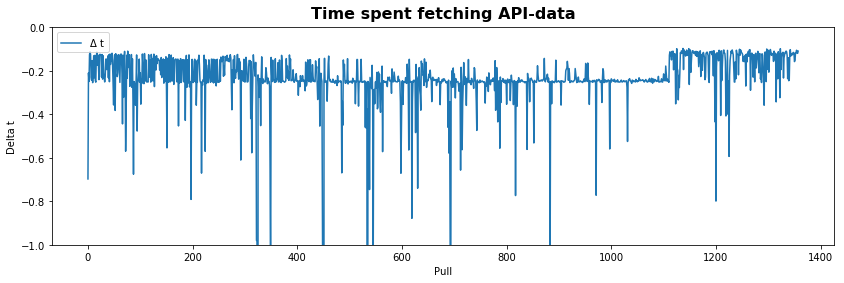

In [21]:
#Setting up the figure:
fig = plt.figure(figsize=(14,4), frameon=False)
title_font = {'size':'16', 'color':'black', 'weight':'bold',
              'verticalalignment':'bottom'}
plt.title('Time spent fetching API-data',**title_font)
#plt.axis('off')

#Figure 1
plt.plot(API_log['id'],API_log['delta_t'],label='$\Delta$ t')
plt.ylabel('Delta t')
plt.xlabel('Pull')
plt.ylim(-1,0)

legend1 = plt.legend(loc = 'upper left', frameon=True)

# 4) Scraping Metro-Data

By scraping danish Wikipedia-sites for Metro stations in Copenhagen, I can find Address, year built and other relevant information.

One problem is, that the information-tables on Wikipedia-pages do not contain the same number of rows and thus amount of information. This is resolved by creating a list of dictionaries, in which each element is a dictionary involving all information from a given table.
Selected information is drawn from here and appended to a finished DataFrame, containing all relevant Metro-information.

## 4.1) Scraping:

In [ ]:
connector = Connector('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Logs/MetroLog.csv',overwrite_log=True,path2selenium='/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Gecko/geckodriver',connector_type='selenium')

In [ ]:
# Defining Scraper-function:
def WikiScraper(no_metros):
    url = 'https://da.wikipedia.org/wiki/Stationer_p%C3%A5_K%C3%B8benhavns_Metro'
    response,call_id = connector.get(url,'Metroer')
    time.sleep(1)

    # Creating DataFrame and dictionary for information-storing:
    data = pd.DataFrame()
    dic_list = []


    for i in range(1,no_metros+1):
        link = connector.browser.find_element_by_xpath(f'/html/body/div[3]/div[3]/div[5]/div/table[1]/tbody/tr[{i}]/td[1]/a')
        link.click()
        time.sleep(1)

        # READ INFORMATION
        # 1.1) Appending all information to DataFrame
        table = pd.read_html(connector.browser.page_source)[0]
        data[f'Traits_{i}'] = table.iloc[:,0]
        data[f'{i}'] = table.iloc[:,1]

        # 1.2) Finding extra information, that the read_html doesn't pick up:
        soup = BeautifulSoup(connector.browser.page_source, 'lxml')
        name = soup.find('h1').text
        data[f'Traits_{i}'][0] = 'Name' # Adding the name to first row of the df (This is always NaN, so doesn't delete vital data)
        data[f'{i}'][0] = name

        # 2) Creating a dictionary with all information, ensuring homogeneity in calls of keys between different WikiPages; the info is in different orders between wiki-sites.:
        dic = {}
        for j in range(0,len(data[f'Traits_{i}'])):
            dic[str(data[f'Traits_{i}'][j])] = str(data[f'{i}'][j])

        dic_list.append(dic)

        # RETURN 
        connector.browser.get(url)
        time.sleep(1)

    return [data,dic_list]
    #return dic_list

In [ ]:
MetroScrape = WikiScraper(44)

In [71]:
MetroLog = pd.read_csv('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Logs/MetroLog.csv',sep=';').head(n=3)
MetroLog

,id,project,connector_type,t,delta_t,url,redirect_url,response_size,response_code,success,error
0,0,Metroer,selenium,1.597668e+09,-0.907827,https://da.wikipedia.org/wiki/Stationer_p%C3%A...,https://da.wikipedia.org/wiki/Stationer_p%C3%A...,126862,NaN,NaN,NaN
1,1,Metroer,selenium,1.597668e+09,-0.659327,https://da.wikipedia.org/wiki/Stationer_p%C3%A...,https://da.wikipedia.org/wiki/Stationer_p%C3%A...,126727,NaN,NaN,NaN
2,2,Metroer,selenium,1.597669e+09,-0.652908,https://da.wikipedia.org/wiki/Stationer_p%C3%A...,https://da.wikipedia.org/wiki/Stationer_p%C3%A...,131090,NaN,NaN,NaN


## 4.2) Working with the data:

Creating a DataFrame using the information from dictionaries:

In [ ]:
indexlist = ['Name','Adresse','Jernbane','Åbningsdato']
MetroList = pd.DataFrame(index=indexlist)

for i in range(0,44):
    specs = []
    for j in indexlist:
        try: 
            specs.append(MetroScrape[1][i][j]) # Appending the relevant Metro-information (j-key from scrape-dict)
        except:
            specs.append('NaN')
    # Indexing column names:
    MetroList[i] = specs
MetroList = MetroList.transpose()
MetroList.columns = ['Name', 'Address', 'Railroad', 'Opening Date'] # Changing names to english


# Cleaning for '[1]' (from Wikipedia-references):
MetroList['Address'] = [i.replace('[1]','') for i in MetroList['Address']]
MetroList['Address'] = [i.replace('[2]','') for i in MetroList['Address']]
MetroList['Railroad'] = [i.replace('[2]','') for i in MetroList['Railroad']]
MetroList['Opening Date'] = [i.replace('[1]','') for i in MetroList['Opening Date']]

# Cleaning NaN-values:
MetroList = MetroList.drop(MetroList["Address"].loc[MetroList["Address"]=='NaN'].index)
MetroList.reset_index(inplace=True)
del MetroList['index']

# Creating dummy-variable for Cityring:
MetroList['Cityring'] = 0
for i in range(0,len(MetroList)):
    if 'Cityringen' in MetroList['Railroad'][i]:
        MetroList['Cityring'][i] = 1

# Simplyfying Opening Date-column to year for use in regression analysis later:
for i in range(0,len(MetroList)):
    try:
        year = int(MetroList['Opening Date'][i][-4:])
        if 0 < year < 2021:
            MetroList['Opening Date'][i] = int(MetroList['Opening Date'][i][-4:])
    except:
        pass

# Cleaning the rest by hand, example: '13. december 1986 (S-tog), 12. oktober 2003 (Metro)' is cleaned to 2003
for i in [7,32]:
    MetroList['Opening Date'][i] = 2003
MetroList['Opening Date'][25] = 2002
for i in [23,27,31,34]:
    MetroList['Opening Date'][i] = 2019
MetroList = MetroList.drop(22)
MetroList.reset_index(inplace=True)
del MetroList['index']

In [ ]:
MetroList.head(n=3)

Seeing that the coordinates returned equals (39.78373,-100.445882) if there's a mistake (mostly, that the door and zip code are not separated by space) in the Address, I fix the very last issues manually in Excel in about a minute. This is no problem, as I am only working with 44 entries, and it would have been relatively difficult using RegEx, as the apartment numbers do not have the same number of digits and sometimes have letters in them. Too heterogenous. Speed before unneeded and superfluously complex code!

In [ ]:
# Saving to Excel:
MetroList.to_excel('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Metro Adresses for Final Touches.xlsx')

In [72]:
# Pulling edited version:
MetroList = pd.read_excel('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Metro Adresses for Final Touches_DONE.xlsx')

In [73]:
del MetroList['Unnamed: 0']
MetroList.head(n=3)

,Name,Address,Railroad,Opening Date,Cityring
0,Aksel Møllers Have Station,Godthåbsvej 31 2000 Frederiksberg,Cityringen,2019,1
1,Amager Strand Station,Italiensvej 72A 2300 København S,Østamagerbanen,2007,0
2,Amagerbro Station,Amagerbro Torv 1 2300 København S,Ørestadsbanen,2002,0


## 4.3) Finding Coordinates to each Metro

In [77]:
MetroList['Coordinates'] = [Geocode_Google(i) for i in MetroList['Address']]

In [78]:
MetroList.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Metrolist With Coordinates.pkl')

In [79]:
MetroList = pickle.load(open('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Metrolist With Coordinates.pkl','rb'))

# 5) Finding the closest metro

The code loops through each apartment in the Apartments dataframe. For each apartment, it sets an initial distance, after which it loops through each metro-station, calculate the distance to the given station, and substitute this for the default distance/metro if this distance is shorter. 

At last, when all metros have been upheld against each other for a given apartment, the key stats on the closest one are appended as a dictionary to the given apartment's row in the Apartments-dataframe

In [84]:
def Closest_Metro(df,from_num,to_num):
    # Creating a list of the closest metro to each apartment with the same index:
    Closest_Metro = []
    # Looping through each apartment:
    for i in df['Coordinates'][from_num:to_num]:
        # Initiating lowest distance and its metro
        lowest_dist = 1000
        # Looping through metros, finding all distances and substituting the shortest one
        for j in range(0,len(MetroList['Coordinates'])):
            dist = geopy.distance.distance(i, MetroList['Coordinates'][j]).km
            if dist < lowest_dist:
                name = MetroList['Name'][j]
                lowest_dist = dist
                add = MetroList['Address'][j]
                railroad = MetroList['Railroad'][j]
                opening_date = MetroList['Opening Date'][j]
                cityring_indicator = MetroList['Cityring'][j]


        Closest_Metro.append({'Name':name,'Distance':lowest_dist,'Address':add,'Railroad':railroad,'Opening Date':opening_date,'Cityring':cityring_indicator})
    return Closest_Metro

In [38]:
Apartments['Closest Metro'] = Closest_Metro(Apartments,0,len(Apartments))

In [85]:
Apartments_API['Closest Metro'] = Closest_Metro(Apartments_API,0,len(Apartments_API))

In [ ]:
Apartments.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data 4.pkl')

In [86]:
Apartments_API.to_pickle('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data API.pkl')

In [25]:
Apartments = pickle.load(open('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Pickles/Apartment Data 4.pkl','rb'))

In [26]:
Apartments[:3].to_excel('/Users/holger/Documents/Python/Harmsen_Repo/Metro-Study/Other data/illustration of df.xlsx')

In [27]:
# The finished product ready for analysis:
Apartments

,Address,Address transformed,Area,Coordinates,Date_sold,Price,Price_mio,Price_sq_m_1000,Rooms,Closest Metro
0,"Stengade 52B, 1. 1, 2200 København N",Stengade 52B 2200 København N,N,"(55.687083, 12.554688)",1994-02-11,300710,0.300710,5.896,1,"{'Name': 'Forum Station', 'Distance': 0.609572..."
1,"Bryggerivej 10, 1. th, 2500 Valby",Bryggerivej 10 2500 Valby,Valby,"(55.660475, 12.518974)",1994-02-11,344101,0.344101,5.550,2,"{'Name': 'Enghave Plads Station', 'Distance': ..."
2,"Solvænget 5, 3. tv, 2100 København Ø",Solvænget 5 2100 København Ø,Ø,"(55.719198, 12.57804)",1994-02-11,1090300,1.090300,7.788,4,"{'Name': 'Poul Henningsens Plads Station', 'Di..."
3,"Ved Volden 8, 5. tv, 1425 København K",Ved Volden 8 1425 København K,K,"(55.67202, 12.594053)",1994-02-13,415000,0.415000,6.694,2,"{'Name': 'Christianshavn Station', 'Distance':..."
4,"Marstalsgade 38, 2. th, 2100 København Ø",Marstalsgade 38 2100 København Ø,Ø,"(55.703961, 12.589622)",1994-02-14,172000,0.172000,3.071,2,"{'Name': 'Nordhavn Station', 'Distance': 0.122..."
...,...,...,...,...,...,...,...,...,...,...
56944,"Rådmandsgade 48A, 2. th, 2200 København N",Rådmandsgade 48A 2200 København N,N,"(55.700733, 12.552838)",2020-07-16,816000,0.816000,14.836,2,"{'Name': 'Vibenshus Runddel Station', 'Distanc..."
56945,"Tycho Brahes Allé 8, 5. tv, 2300 København S",Tycho Brahes Allé 8 2300 København S,S,"(55.6552045, 12.6111575)",2020-07-16,1875000,1.875000,36.765,2,"{'Name': 'Lergravsparken Station', 'Distance':..."
56946,"Theklavej 49, 2. 79, 2400 København NV",Theklavej 49 2400 København NV,V,"(55.7059296, 12.5251929)",2020-07-16,1550000,1.550000,38.750,1,"{'Name': 'Nørrebro Station', 'Distance': 0.980..."
56947,"Sundkaj 75, 3. th, 2150 Nordhavn",Sundkaj 75 2150 Nordhavn,NaN,"(55.7100897, 12.5977136)",2020-07-16,3570000,3.570000,51.000,2,"{'Name': 'Orientkaj Station', 'Distance': 0.13..."
